In [1]:
import json
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.defchararray import find
from pandas.api.types import CategoricalDtype
from scipy import stats
from sklearn import linear_model, preprocessing
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve, confusion_matrix
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from tqdm import tqdm

In [2]:
FONTSIZE = 14
plt.rcParams["font.size"] = FONTSIZE

In [3]:
PATH_ROOT = os.path.join(pathlib.Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [4]:
df_cm = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_cmeasures_nn.csv'))
df_cm = df_cm.sort_values(by=['Data', 'Rate'], ignore_index=True)
df_cm.head()

,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,C2,Density,ClsCoef,Hubs,HubsSD,Rate,Filepath,Testpath,Train,Test
0,f04_i02_r00_c01_w6_1,0.810730,0.372452,0.054200,0.334868,0.504,0.4245,0.030,0.200008,0.109163,...,0.077664,0.848518,0.406686,0.766283,0.302880,0.00,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_clean_...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.985,0.994
1,f04_i02_r00_c01_w6_1,0.871642,0.236221,0.157394,0.478438,0.762,0.6860,0.082,0.262551,0.115698,...,0.020594,0.862773,0.400181,0.770124,0.299065,0.05,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.934,0.994
2,f04_i02_r00_c01_w6_1,0.898315,0.188025,0.250773,0.565290,0.690,0.6360,0.126,0.264643,0.140696,...,0.278243,0.865011,0.415929,0.642544,0.312808,0.10,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.889,0.932
3,f04_i02_r00_c01_w6_1,0.924654,0.092116,0.302377,0.436307,0.690,0.6140,0.115,0.279178,0.123644,...,0.019025,0.870060,0.382698,0.761814,0.292958,0.15,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.881,0.895
4,f04_i02_r00_c01_w6_1,0.932818,0.088960,0.343645,0.512272,0.631,0.5850,0.107,0.261546,0.134748,...,0.532007,0.863499,0.437701,0.639688,0.248479,0.20,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.831,0.694


In [5]:
print(df_cm.shape)
print(df_cm.columns)

(2697, 34)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD',
       'Rate', 'Filepath', 'Testpath', 'Train', 'Test'],
      dtype='object')


In [6]:
# Split datasets into 3 difficulties
# Compute dataset difficulty based on test set accuracy
DIF_LEVELS = ['Hard', 'Normal', 'Easy']
N_BINS = len(DIF_LEVELS)
difficulty_mapping = {0: DIF_LEVELS[0], 1: DIF_LEVELS[1], 2: DIF_LEVELS[2]}

encoder = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform')
acc_test_clean = df_cm[df_cm['Rate'] == 0]['Test'].to_numpy()
ordinal_clean = encoder.fit_transform(acc_test_clean.reshape([-1, 1])).flatten().astype(int)

print('Convert test set accuracy into ordinal data:')
for i in range(N_BINS):
    start = encoder.bin_edges_[0][i]
    end = encoder.bin_edges_[0][i+1]
    print('{} in [{:.3f}, {:.3f})'.format(DIF_LEVELS[i], start, end))

Convert test set accuracy into ordinal data:
Hard in [0.490, 0.658)
Normal in [0.658, 0.826)
Easy in [0.826, 0.994)


In [7]:
POISON_LVLS = np.round(np.arange(0, 0.41, 0.05, dtype=float), 2)
POISON_LVLS

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [8]:
datanames = df_cm[df_cm['Rate'] == 0]['Data'].to_numpy()
df_cm['Difficulty'] = 0
for data, dif in zip(datanames, ordinal_clean):
    idx = df_cm[df_cm['Data'] == data].index
    df_cm.loc[idx, ['Difficulty']] = dif

df_cm['Difficulty'] = df_cm['Difficulty'].replace(difficulty_mapping)

In [9]:
col_X = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD'
]
col_y = 'Test'

In [10]:
N_ITER_SEARCH = 100

regressor = linear_model.Ridge()
param = {'alpha': loguniform(1e-4, 10),}
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(df_cm[col_X], df_cm[col_y])

best_param = param_search.best_estimator_.get_params()
print('Best params:')
print(best_param)

Best params:
{'alpha': 0.025264718959818085, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


In [11]:
alpha = 0.03
N_FOLD = 5

df_cm['prediction'] = 0

# Split by clean data
indices_clean = df_cm[df_cm['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(indices_clean):
    idx_train_clean = indices_clean[i_train]
    idx_test_clean = indices_clean[i_test]

    data_train = df_cm.loc[idx_train_clean, 'Data']
    data_test = df_cm.loc[idx_test_clean, 'Data']

    idx_train = df_cm[df_cm['Data'].isin(data_train)].index
    idx_test = df_cm[df_cm['Data'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df_cm.shape[0]

    X_train = df_cm.loc[idx_train, col_X]
    y_train = df_cm.loc[idx_train, col_y]
    X_test = df_cm.loc[idx_test, col_X]
    y_test = df_cm.loc[idx_test, col_y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df_cm.loc[idx_test, 'prediction'] = regressor.predict(X_test)
    

In [12]:
# Clip prediction above 1
predictions = df_cm['prediction'].to_numpy()
df_cm['prediction'] = np.amin([predictions, np.ones_like(predictions)], axis=0)

In [13]:
rmse = np.sqrt(mean_squared_error(df_cm['Test'].to_numpy(), df_cm['prediction'].to_numpy()))
print('RMSE test: {:.3f}'.format(rmse))

RMSE test: 0.072


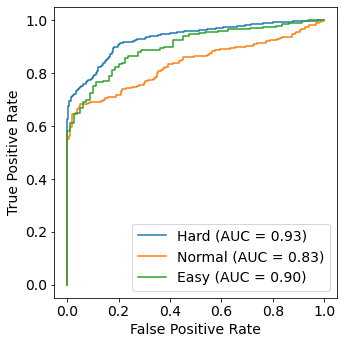

In [14]:
FIGSIZE = (5, 5)
THRESHOLD = 0.05

fig, ax = plt.subplots(figsize=FIGSIZE)
for difficulty in DIF_LEVELS:
    df_ = df_cm[df_cm['Difficulty'] == difficulty]
    y_true_ = (df_['Rate'] > THRESHOLD).astype(int)
    # y_true_ = (df_['Rate'] != 0).astype(int)
    y_score_ = np.abs(df_['prediction'] - df_['Train'])
    fpr_, tpr_, _ = roc_curve(y_true_, y_score_)
    roc_auc_ = auc(fpr_, tpr_)
    roc_display = RocCurveDisplay(fpr=fpr_, tpr=tpr_, roc_auc=roc_auc_).plot(ax=ax, name=difficulty)
ax.set_title('')
plt.tight_layout()
path_output = os.path.join(PATH_ROOT, 'results', 'roc_synth.pdf')
plt.savefig(path_output, dpi=300)